# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm

In [2]:
import sys
import os

# File path to the src directory for both linux and windows
# workaround for the issue of relative imports in Jupyter notebooks to import modules from src without using the full path
src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [3]:
# Rerun this cell after making changes to the utils module
from the_team.utils import etl, viz
import importlib
importlib.reload(etl)
importlib.reload(viz)

# Set custom plot style for consistency
viz.set_plot_style()

/opt/anaconda3/envs/kedro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - Custom plot style set.


# Before Cleaning

In [4]:
RAW_DIR = Path("data") / "01_raw"

In [5]:
# Load datasets
customers = etl.load_csv(RAW_DIR / "olist_customers_dataset.csv")
geolocation = etl.load_csv(RAW_DIR / "olist_geolocation_dataset.csv")
items = etl.load_csv(RAW_DIR / "olist_order_items_dataset.csv")
payments = etl.load_csv(RAW_DIR / "olist_order_payments_dataset.csv")
reviews = etl.load_csv(RAW_DIR / "olist_order_reviews_dataset.csv")
orders = etl.load_csv(RAW_DIR / "olist_orders_dataset.csv")
products = etl.load_csv(RAW_DIR / "olist_products_dataset.csv")
sellers = etl.load_csv(RAW_DIR / "olist_sellers_dataset.csv")
translation = etl.load_csv(RAW_DIR / "product_category_name_translation.csv")

### Geolocation-related datasets [Jin Bin]
- customers.csv
- geolocation.csv
- sellers.csv

### Review-related datasets [Habib]
- review.csv
- products.csv
- translation.csv

#### Review dataset


In [6]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [8]:
# .info shows missing entries
etl.null_duplicate_check(reviews)

WARNING - Null values found.


INFO - 90.08% or 89385 rows have 1 or more null values.
INFO - Null value counts per column:
INFO - review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64
INFO - No duplicates found.


In [9]:
# Step 1) Since many users about 90% did not give their comments a title I will drop the title column as the data is not complete enough, the review date/timestamp are not relevant as 
# there is no time aspect in this situation so that will be dropped as well. The Review Id is also not required as its just used to index the reviews and this is not relevant.

reviews.drop(columns=["review_id", "review_comment_title","review_creation_date", "review_answer_timestamp"], inplace=True)

reviews.head()

# Dataset is now less bloated and only relevant columns remain.

,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,NaN
1,a548910a1c6147796b98fdf73dbeba33,5,NaN
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...


INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


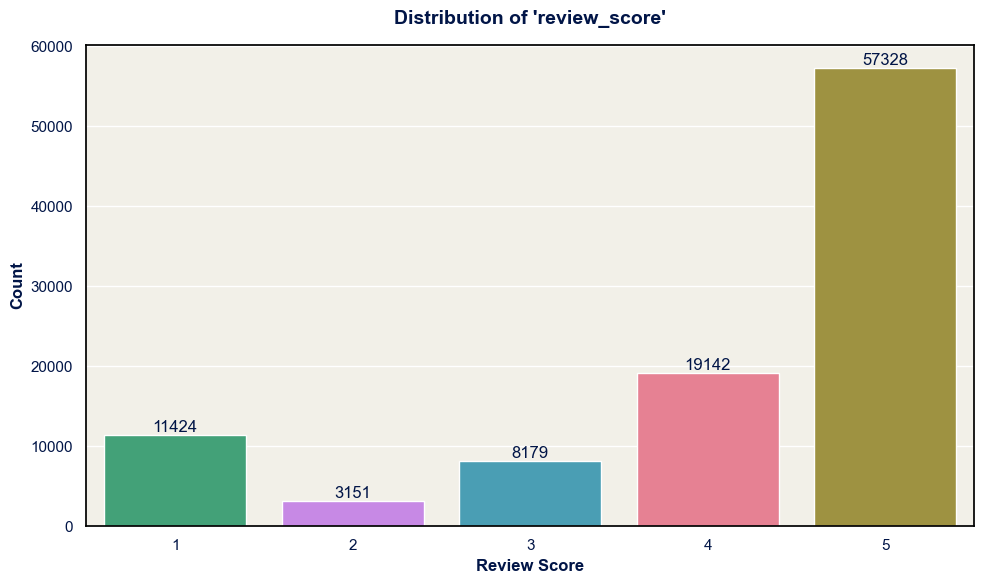

In [10]:
# Lets take a look at the spread of the review scores before any validation.

viz.plot_categorical_distribution(reviews, "review_score")

- We can see that there is a large bias towards 5 & 4 point reviews suggesting about 1 in 3 orders are satisfactory and leave a posititve impression on the end user.
- However there is a large amount of neutral reviews. To prevent non useful datapoints, this will be checked against the sentiment of the comments to verify all ratings are as intended.

#### Products dataset

In [11]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [13]:
# .info shows small amount of missing entries
etl.null_duplicate_check(products)

WARNING - Null values found.
INFO - 1.85% or 611 rows have 1 or more null values.
INFO - Null value counts per column:
INFO - product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
INFO - No duplicates found.


In [14]:
# 2) There is no possible way to feature engineer or substitute placeholder values for any of the columns so I will drop any df row with no data entries

products.dropna(inplace=True)

etl.null_duplicate_check(products)

# No further actions with this dataset as I will use the data to figure out if product category and size have an effect on user satisfaction so all columns are relevant

INFO - No duplicates found.


No null values found.


#### Translation Dataset

In [15]:
translation.head()
# From what I can see, this is a small dataset for end users to translate the portuguese labeled items.

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [16]:
translation.info()
# There are no missing or duplicate values. Nor any further visualisations, so I will leave this dataset as is and may use it in the future for sentiment analysis of product categories.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


### Order-related datasets [Min]
- items.csv
- payments.csv
- orders.csv

#### items.csv

In [6]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
# df info says no Null but still; Null and duplicate check
etl.null_duplicate_check(items)

INFO - No duplicates found.


No null values found.


In [9]:
# 1. shipping_limit_date has wrong data type.
items["shipping_limit_date"] = etl.to_datetime(items["shipping_limit_date"])
assert items["shipping_limit_date"].dtype == "datetime64[ns]", "shipping_limit_date should be datetime64[ns]"

# 2. order_id has wrong data type, but it's not useful for our business goal since it's just indexing items in an order.
# Thus, we can drop it.
items.drop(columns=["order_item_id"], inplace=True)

# Some duplicates are expected after dropping order_item_id, since there can be multiple items in an order.
# Left untreated as these duplicates are identifiable and workable with the order_id.
etl.null_duplicate_check(items, verbose=False)

WARNING - Duplicates found.
INFO - 9.08% or 10225 rows are complete duplicates.


No null values found.


In [10]:
# Check distribution of numeric columns
items.describe()

,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650.000000
mean,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,2016-09-19 00:15:34,0.850000,0.000000
25%,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,2018-01-26 13:59:35,74.990000,16.260000
75%,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,2020-04-09 22:35:08,6735.000000,409.680000
std,NaN,183.633928,15.806405


- A large gap between the 75th percentile (Q3) and the maximum indicates that there are high-value outliers. 
- Olist dataset distributor mentioned (in Kaggle) that the data is from 2016 to 2018.

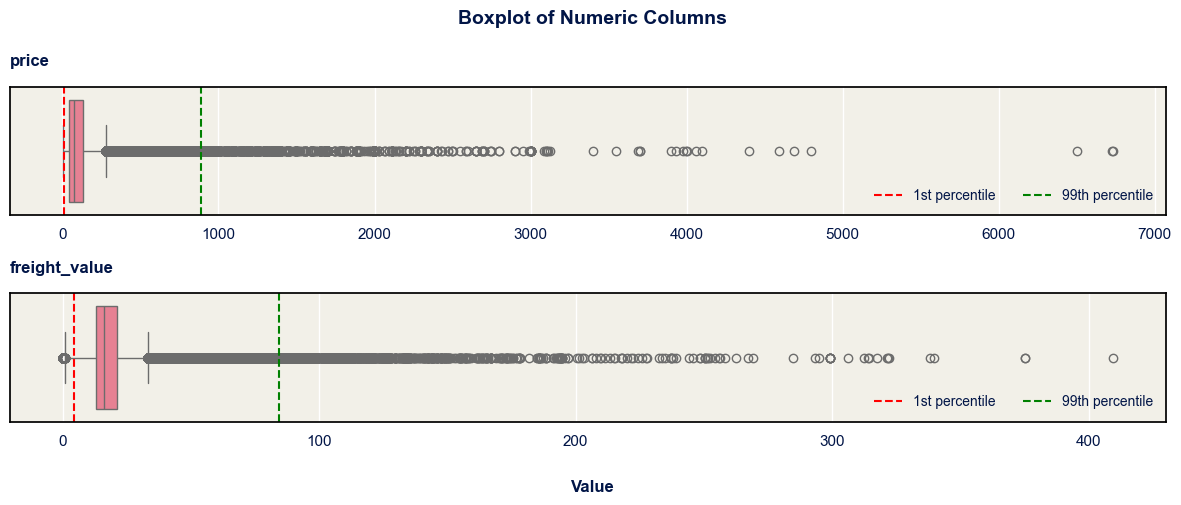

In [11]:
# 3. Drop rows not within 2016-2018
items = items[items["shipping_limit_date"].dt.year.isin([2016, 2017, 2018])]

# Plot distribution of numeric columns
viz.plot_numeric_distribution(items)

- Both price & freight_value columns show strong right-skewed distributions with a large number of high-value outliers, which is expected as people mostly buy FMCGs (with low cost) from online, not high-end products.
- Right-skewed price means the item is expensive while right-skewed freight_value means either the customer lives far away from sellers or the item is physically huge; this can be cross-checked later with geolocation and product data.

In [12]:
price_99p = items['price'].quantile(0.999)
print(f"99.9% of price is ${price_99p}.")
freight_99p = items['freight_value'].quantile(0.999)
print(f"99.9% of freight_value is ${freight_99p:.2f}.")

99.9% of price is $2110.0.
99.9% of freight_value is $175.59.


High values in both price and freight_value are important as they may suggest:
- People who bought expensive quality producuts are less likely to buy again. 
- People who have to pay high freight_value are less likely to buy again. 
But, capturing 99.9% of current customers should be representative enough. 

In [13]:
# 4. Remove outliers
items['price'] = etl.cap_outliers(items['price'], min_cap=False, max_cap=99.9)
items['freight_value'] = etl.cap_outliers(items['freight_value'], min_cap=False, max_cap=99.9)

In [16]:
# 5. Flag high values for the model to learn that a price/freight is unusually high (usual outliers)
items['price_high'] = items['price'] > items['price'].quantile(0.75) * 1.5
items['freight_value_high'] = items['freight_value'] > items['freight_value'].quantile(0.75) * 1.5
items.freight_value_high.value_counts()

freight_value_high
False    100350
True      12296
Name: count, dtype: int64

#### orders.csv

In [17]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [19]:
# 1. Convert to datetime and clip to 2016-2018
for col in orders.columns[3:]:
    orders[col] = etl.clip_datetime(orders[col])
    assert orders[col].dtype == "datetime64[ns]", f"{col} should be datetime64[ns]"

- order_delivered_carrier_date (which marks when the seller handed the package to the carrier) is mainly for logistic purposes and does not influence repeat buyer behaviour as comparied to the duration between purchase and delivery.

In [20]:
# 2. Drop order_delivered_carrier_date
orders.drop(columns=["order_delivered_carrier_date"], inplace=True)
assert "order_delivered_carrier_date" not in orders.columns, "order_delivered_carrier_date should be dropped"

# Null values
etl.null_duplicate_check(orders)

WARNING - Null values found.
INFO - 3.00% or 2979 rows have 1 or more null values.
INFO - Null value counts per column:
INFO - order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
INFO - No duplicates found.


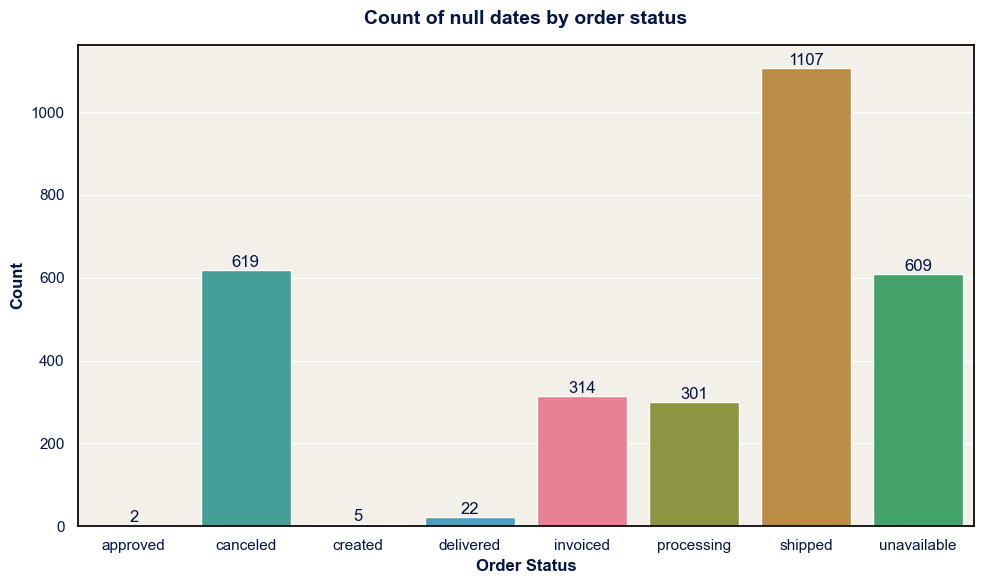

In [21]:
# ~3% of the data shows that the order_delivered_customer_date is null
# meaning that the order was not delivered or have not been delivered yet to the customer

# Check if null dates are related to different order statuses
null_dates_orders = orders[orders.isnull().any(axis=1)].copy()
viz.plot_categorical_distribution(null_dates_orders, "order_status", "Count of null dates by order status")

- Since the goal is to identify potential repeat buyer, we will focus on 'paid' statuses; dropping others while trying to impute the null values.

WARNING - NaN values found in datetime columns. They will be ignored in duration calculation.


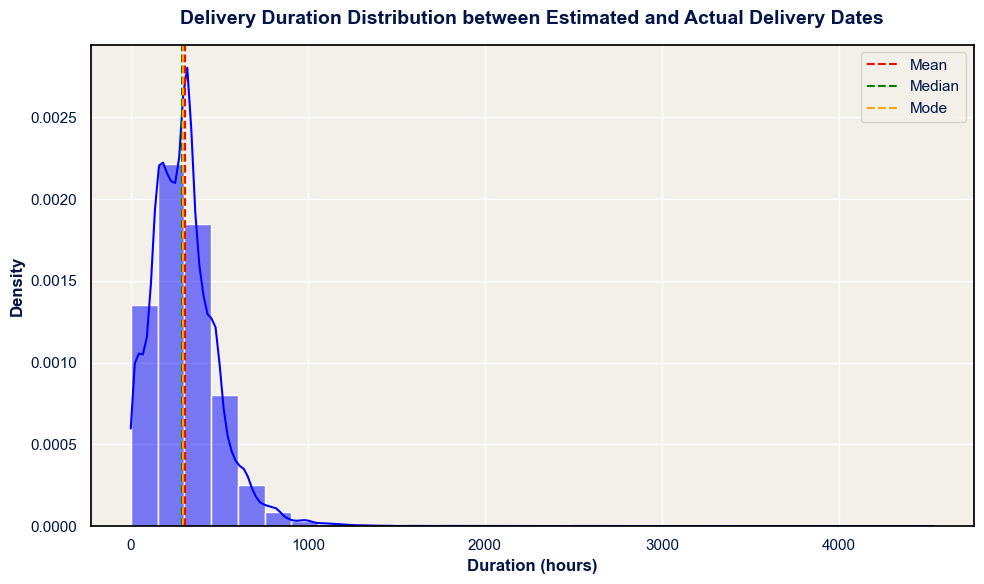

In [22]:
# 3. Drop rows with [canceled, created, invoiced, unavailable] order_status
orders = orders[~orders["order_status"].isin(["canceled", "created", "invoiced", "unavailable"])]

# Vislualize the duration between order_approved_at and order_delivered_customer_date
mean, median, mode = viz.plot_duration_distribution(
                        df=orders,
                        column_x='order_delivered_customer_date',
                        column_y='order_estimated_delivery_date',
                        title='Delivery Duration Distribution between Estimated and Actual Delivery Dates',
                    )

- The duration is right-skewed, and the mean is dragged towards right due to extreme outliers. 

In [23]:
# 4. Fill null values in order_delivered_customer_date with the median duration
orders["order_delivered_customer_date"] = orders["order_delivered_customer_date"].fillna(orders["order_estimated_delivery_date"] - median) # type: ignore
assert orders["order_delivered_customer_date"].isnull().sum() == 0, "There should be no null values in order_delivered_customer_date"

# For null order_approved_at,
orders[orders.order_approved_at.isna()]['order_status'].value_counts()

order_status
delivered    14
Name: count, dtype: int64

- order_status shows delivered, but order_approved_at (payment time) and order_delivered_customer_date is null, meaning these are mix-mactched; incorrect data (maybe the customer used points to exchange instead of payment?)


In [24]:
# 5. drop NULL in order_approved_at
orders.dropna(inplace=True)
assert orders.isnull().sum().sum() == 0, "There should be no null values in the dataset as of now."